In [10]:
!pip install -U --no-cache-dir gdown --pre
!gdown https://drive.google.com/uc?id=1qhJQG_VjE1A2lkCgwNX6ZYEjJlsKPfgC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Downloading...
From: https://drive.google.com/uc?id=1qhJQG_VjE1A2lkCgwNX6ZYEjJlsKPfgC
To: /content/GSM5057469_Human_matrix.mcool
100% 1.36G/1.36G [00:13<00:00, 99.4MB/s]


In [11]:
import matplotlib.pyplot as plt
!pip install cooler
import cooler
import numpy as np
import scipy as scp
import enum

class HiCnormType(enum.Enum):
    raw = 1 # raw Hi-C matrix with int data values
    IC = 2  # Iterative Correction.
    VC = 3  # Vanilla-Coverage. This is a simple method where at first each element is divided by sum of respective row and subsequently divided by sum of respective column.

def get_HiC_matrix(path, 
                   resolution=2000,
                   sparse=False,
                   norm_type=HiCnormType.IC,
                   set_zero_diag=True,
                   chromname = None, #'chrI'
                   tol=1e-10):
    
    if resolution != 0:
        path = path + "::/resolutions/{}".format(resolution)
        
    cool = cooler.Cooler(path) # ['/resolutions/200', '/resolutions/400', '/resolutions/800', '/resolutions/1600', '/resolutions/2000']
    
    matrix = None
    if norm_type == HiCnormType.raw:
        if chromname == None:
            matrix = cool.matrix(sparse=sparse, balance=False)[:, :]
        else:
            matrix = cool.matrix(sparse=sparse, balance=False).fetch(chromname)
    elif norm_type == HiCnormType.IC:
        if chromname == None:
            matrix = cool.matrix(sparse=sparse, balance=True)[:, :]
        else:
            matrix = cool.matrix(sparse=sparse, balance=True).fetch(chromname)
    elif norm_type == HiCnormType.VC:
        if chromname == None:
            matrix = cool.matrix(sparse=sparse, balance=False)[:, :]
        else:
            matrix = cool.matrix(sparse=sparse, balance=False).fetch(chromname)
        
        dim = matrix.shape[0]
        
        sum_along_row = np.asarray(matrix.sum(axis=1)).reshape(-1).astype(np.float64)
        for i in range(dim):
            if sum_along_row[i] > tol:
                sum_along_row[i] = 1 / sum_along_row[i]
            else:
                sum_along_row[i] = 0
        spdiag_inv_sum_along_row = scp.sparse.diags(sum_along_row)
        #matrix = spdiag_inv_sum_along_row @ matrix     # we divide each row by the sum of all its elements
        
        sum_along_column = np.asarray(matrix.sum(axis=0)).reshape(-1).astype(np.float64)
        for i in range(dim):
            if sum_along_column[i] > tol:
                sum_along_column[i] = 1 / sum_along_column[i]
            else:
                sum_along_column[i] = 0
        spdiag_inv_sum_along_column = scp.sparse.diags(sum_along_column)
        #matrix = matrix @ spdiag_inv_sum_along_column  # we divide each column by the sum of all its elements
    
        matrix = spdiag_inv_sum_along_row @ matrix @ spdiag_inv_sum_along_column
    
    if set_zero_diag == True:
        if sparse == False:
            np.fill_diagonal(matrix, 0)  # matrix is a dense numpy.ndarray
        else:
            matrix.setdiag(0)            # matrix is a sparse scipy.sparse._coo.coo_matrix. Can be further converted to CSR/CSC format for fast arithmetic and matrix vector operations (.tocsr()).
    
    if scp.sparse.issparse(matrix)==False:
        matrix = np.nan_to_num(matrix)
    
    return matrix
    
    
def construct_Kirchhoff_mat(matrix, gamma=1):
    # zero all diagonal elements (in case if they are != 0)
    if scp.sparse.issparse(matrix) == False:
        np.fill_diagonal(matrix, 0)
    else:
        matrix.setdiag(0)
    
    sum_along_row = np.asarray(matrix.sum(axis=1)).reshape(-1).astype(np.float64) * gamma
    matrix *= -gamma
    if scp.sparse.issparse(matrix) == False:
        np.fill_diagonal(matrix, sum_along_row)
    else:
        matrix.setdiag(sum_along_row)
    
    return matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import scipy as scp

def compute_eigen_decomp(matrix, k=6, which='SM'):
    eigvals = None
    eigvecs = None
    if scp.sparse.issparse(matrix):
        eigvals, eigvecs = scp.sparse.linalg.eigsh(matrix, k=k, which=which)
    else:
        eigvals, eigvecs = np.linalg.eigh(matrix)
    return eigvals, eigvecs

def compute_cross_correlation_matrix(eigvals, eigvecs, tol=1e-10):
    dim = len(eigvals)
    cross_cor_mat = np.zeros(dim, dim)
    for i in range(dim):
        if eigvals[i] > tol:
            cross_cor_mat += np.outer(eigvecs[i], eigvecs[i]) / eigvals[i]

def compute_cross_correlation_diagonal(eigvals, eigvecs, normalize=True, tol=1e-10):
    dim = len(eigvals)
    cross_cor_mat_diagonal = np.zeros(dim)
    for i in range(dim):
        if eigvals[i] > tol:
            cross_cor_mat_diagonal += eigvecs[i]**2 / eigvals[i]
            
    if normalize == True:
        cross_cor_mat_diagonal /= np.linalg.norm(cross_cor_mat_diagonal, 2) #.max()
    return cross_cor_mat_diagonal

In [13]:
import numpy as np

def save_array(array, filename='data'):
    filename += '.npy'
    np.save(filename, array) 
    
def read_array(filename):
    array = np.load(filename)
    return array

In [14]:
HiC_mat = get_HiC_matrix('GSM5057469_Human_matrix.mcool',
                   resolution=50000, sparse=False, chromname = 'chr2', norm_type=HiCnormType.IC)

print("HiC_mat.shape =", HiC_mat.shape)

HiC_mat.shape = (4844, 4844)


In [15]:
eigdecomp_HiC_mat = compute_eigen_decomp(HiC_mat)
eigvals_HiC_mat, eigvecs_HiC_mat = eigdecomp_HiC_mat

In [16]:
np.argmax(eigvals_HiC_mat)

4843

In [17]:
K_mat = construct_Kirchhoff_mat(HiC_mat, gamma=1)

#K_mat.todense()[:5, :5]
#K_mat[:5, :5]
#plt.spy(K_mat, markersize=0.1)
#plt.show()

In [18]:
eigdecomp = compute_eigen_decomp(K_mat)
eigvals, eigvecs = eigdecomp[0], eigdecomp[1]

In [19]:
cross_cor_mat_diagonal = compute_cross_correlation_diagonal(eigvals, eigvecs, normalize=True)

In [20]:
eigvals

array([-1.01472221e-15, -9.75813743e-16, -9.16105630e-16, ...,
        8.92216477e-01,  8.94543223e-01,  9.00294412e-01])

In [21]:
# https://shainarace.github.io/LinearAlgebra/chap1-5.html#spectral
print("Hence there are {} disjoint components in the graph!".format((eigvals < 1e-10).sum()))

Hence there are 262 disjoint components in the graph!


plt.plot(range(0, len(eigvals)),
         np.sort(eigvals), marker='o', markersize=3.1, label='eigvals')
plt.grid()
plt.legend()
plt.show()


fig, ax = plt.subplots()
p = ax.imshow(HiC_mat[:100, :100], cmap='plasma')# cmap='OrRd')
fig.colorbar(mappable=p, ax=ax)
plt.show()


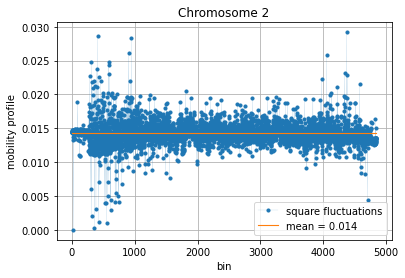

In [22]:

plt.plot(cross_cor_mat_diagonal, marker='o', markersize=3.1, linewidth=0.1, label='square fluctuations')
plt.plot([0, len(cross_cor_mat_diagonal)], [cross_cor_mat_diagonal.mean(), cross_cor_mat_diagonal.mean()],
         linewidth=1.1, label='mean = {}'.format(np.round(cross_cor_mat_diagonal.mean(), decimals=3)))

plt.title("Chromosome 2")
plt.xlabel("bin")
plt.ylabel("mobility profile")

#max_eigvec_num = np.argmax(eigvals_HiC_mat)
#eigvecs_HiC_mat_max = eigvecs_HiC_mat[max_eigvec_num]
#plt.plot(eigvecs_HiC_mat_max, marker='o', markersize=3.1, label='eigvecs_HiC_mat_max')

#plt.ylim(0, 0.025)

#plt.scatter(range(len(cross_cor_mat_diagonal)), cross_cor_mat_diagonal, marker='o', linewidth=0.01, label='cross_cor_mat_diagonal')
#plt.scatter(range(len(eigvecs_HiC_mat)), eigvecs_HiC_mat[max_eigvec_num], marker='o', linewidth=0.01, label='eigvec {}'.format(eigvec_num))

plt.grid()
plt.legend()

#plt.savefig("plot_2.pdf", bbox_inches='tight')
plt.show()

In [23]:
cross_cor_mat_diagonal.mean()

0.014266094445081031

In [24]:
status_arr = np.sign(cross_cor_mat_diagonal - cross_cor_mat_diagonal.mean())
status_arr

array([ 1.,  1.,  1., ..., -1., -1., -1.])